# Heart Attack Prediction

**Programmazione di Applicazioni Data Intensive**

**Lorenzo Dall'Ara**, lorenzo.dallara2@studio.unibo.it\
**Miriam Sonaglia**, miriam.sonaglia@studio.unibo.it

### Fonti Dataset:
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-risk-dataset-of-china \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-prediction-in-united-states \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-risk-and-prediction-dataset-in-india/data \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-prediction-in-indonesia

## Obiettivo del progetto

Questo progetto si pone l'obiettivo di realizzare un modello in grado di predire, in base a caratteristiche proprie del paziente, un possibile rischio di infarto.

## Import delle librerie
Vengono importate le librerie sotto descritte:
* **Pandas** per manipolazione e gestione di dati tabellari
* **Sklearn** per l'analisi predittiva
* **Matplotlib** per la creazione di grafici

In [330]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
CHINA_DATASET = "heart_attack_china.csv"
US_DATASET = "heart_attack_us.csv"
INDIA_DATASET = "heart_attack_india.csv"
INDONESIA_DATASET = "heart_attack_indonesia.csv"
china = pd.read_csv(CHINA_DATASET, sep=",")
unitedStates = pd.read_csv(US_DATASET, sep=",")
india = pd.read_csv(INDIA_DATASET, sep=",")
indonesia = pd.read_csv(INDONESIA_DATASET, sep=",")

In [331]:
# FUNZIONE PER OUTCOME TRUE PER OGNI VALORE
targetCorrelation = lambda df, key, targetKey='Outcome': df.groupby(key, observed=False)[targetKey].mean()*100

## Caricamento e Preprocessing dei dati
### Scelta e Denominazione delle colonne
Si è proceduto alla selezione delle variabili compatibili tra i quattro dataset, individuandone le colonne comuni e rinominandole in modo univoco.

Le colonne scelte sono quindi:
* **PatientID**: identificatore univoco del paziente
* **Age**: età del paziente
* **Gender**: genere del paziente, può assumere i valori "Male" o "Female"
* **IncomeLevel**: guadagno annuo del paziente, può assumere i valori "Low", "Middle" o "High"
* **Hypertension**: indica se il paziente soffre o meno di ipertensione arteriosa
* **Diabetes**: indica se il paziente soffre o meno di diabete
* **Cholesterol**: indica il livello di colesterolo del paziente, può assumere i valori "Low", "Normal" o "High"
* **Obesity**: indica se il paziente sia affetto o meno da obesità (AFFETTO DA??????????)
* **FamilyHistory**: indica se qualche membro della famiglia del paziente abbia avuto o meno un infarto in passato
* **Smoker**: indica se il paziente sia o meno un fumatore
* **AlcoholConsumption**: indica se il paziente sia tendente o meno al consumo di alcohol
* **PhysicalActivity**: indica se il paziente svolge o meno attività fisica
* **HealthyDiet**: indica se il paziente segua o meno una dieta sana
* **StressLevel**: indica il livello di stress del paziente, può assumere i valori 'Low', 'Moderate' o 'High'
* **BloodPressure**: indica il valore della pressione sistolica del paziente
* **PreviousHeartAttack**: indica se il paziente abbia avuto o meno altri infarti in passato
* **Outcome**: indica se il paziente abbia avuto o meno un infarto
* **State**: indica lo stato di provenienza del paziente (Cina, Stati Uniti, India, Indonesia)

In [332]:
china['State'] = "China"
india['State'] = "India"
unitedStates['State'] = "United States"
indonesia['State'] = "Indonesia"

unitedStates["PatientID"] = range(1, len(unitedStates)+1)
indonesia["PatientID"] = range(1, len(indonesia)+1)

In [333]:
(
    unitedStates.drop(
        columns = ['EducationLevel',
                   'ST_Depression',
                   'EmploymentStatus',
                   'MaritalStatus',
                   'Ethnicity',
                   'Medication',
                   'ChestPainType',
                   'ECGResults',
                   'ExerciseInducedAngina',
                   'Slope',
                   'NumberOfMajorVessels',
                   'Thalassemia',
                   'StrokeHistory',
                   'Residence',
                   'MaxHeartRate',
                   'HeartRate'
                  ],
        inplace=True
    )
)

In [334]:
unitedStates.rename(columns = {'BMI':'Obesity', 'Income':'IncomeLevel', 'Patient_ID':'PatientID', 'Diet':'HealthyDiet'}, inplace=True)

In [335]:
(
    china.drop(
        columns = ['Education_Level',
                   'Employment_Status',
                   'Air_Pollution_Exposure',
                   'Healthcare_Access',
                   'Rural_or_Urban',
                   'Region',
                   'Province',
                   'Hospital_Availability',
                   'TCM_Use',
                   'Chronic_Kidney_Disease',
                   'CVD_Risk_Score'
                  ],
        inplace=True
    )
)

In [336]:
china.rename(
    columns = {
        'Patient_ID':'PatientID',
        'Smoking_Status':'Smoker',
        'Cholesterol_Level':'Cholesterol',
        'Physical_Activity': 'PhysicalActivity',
        'Diet_Score':'HealthyDiet',
        'Income_Level':'IncomeLevel',
        'Blood_Pressure':'BloodPressure',
        'Previous_Heart_Attack': 'PreviousHeartAttack',
        'Family_History_CVD': 'FamilyHistory',
        'Stress_Level':'StressLevel',
        'Alcohol_Consumption': 'AlcoholConsumption',
        'Heart_Attack' : 'Outcome'
    },
    inplace=True
)

In [337]:
(
    india.drop(
        columns = ['State_Name',
                   'Triglyceride_Level',
                   'LDL_Level',
                   'HDL_Level',
                   'Diastolic_BP',
                   'Air_Pollution_Exposure',
                   'Healthcare_Access',
                   'Emergency_Response_Time',
                   'Health_Insurance'
                  ],
        inplace=True
    )
)

In [338]:
india.rename(
    columns = {
        'Patient_ID':'PatientID',
        'Smoking':'Smoker',
        'Alcohol_Consumption': 'AlcoholConsumption',
        'Physical_Activity': 'PhysicalActivity',
        'Diet_Score':'HealthyDiet',
        'Cholesterol_Level':'Cholesterol',
        'Systolic_BP':'BloodPressure',
        'Family_History':'FamilyHistory',
        'Stress_Level':'StressLevel',
        'Heart_Attack_History':'PreviousHeartAttack',
        'Annual_Income':'IncomeLevel',
        'Heart_Attack_Risk':'Outcome'
    },
    inplace=True
)

In [339]:
(
    indonesia.drop(
        columns = ['region',
                   'waist_circumference',
                   'air_pollution_exposure',
                   'sleep_hours',
                   'blood_pressure_diastolic',
                   'fasting_blood_sugar',
                   'cholesterol_hdl',
                   'cholesterol_ldl',
                   'triglycerides',
                   'EKG_results',
                   'medication_usage',
                   'participated_in_free_screening'
                  ],
        inplace=True
    )
)

In [340]:
indonesia.rename(
    columns = {
        'age':'Age',
        'gender':'Gender',
        'income_level': 'IncomeLevel',
        'hypertension':'Hypertension',
        'diabetes':'Diabetes',
        'cholesterol_level':'Cholesterol',
        'obesity':'Obesity',
        'family_history':'FamilyHistory',
        'smoking_status':'Smoker',
        'alcohol_consumption':'AlcoholConsumption',
        'physical_activity':'PhysicalActivity',
        'dietary_habits':'HealthyDiet',
        'stress_level':'StressLevel',
        'blood_pressure_systolic':'BloodPressure',
        'previous_heart_disease':'PreviousHeartAttack',
        'heart_attack':'Outcome',
    },
    inplace=True
)

In [341]:
dfs = {
    "China": china,
    "India": india,
    "United States": unitedStates,
    "Indonesia" : indonesia
}

# insieme di tutte le colonne
all_columns = set().union(*(df.columns for df in dfs.values()))

# colonne mancanti per ogni dataset
diff_columns = {
    name: sorted(all_columns - set(df.columns))
    for name, df in dfs.items()
}

diff_columns

{'China': [], 'India': [], 'United States': [], 'Indonesia': []}

### Uniformazione dei tipi di dato
Si è proceduto alla standardizzazione del formato dei dati per ogni colonna, al fine di prevenire incongruenze durante l'elaborazione.

### Ottimizzazione dei dati   (VEDI SE METTERE QUA O SOTTO)
Al fine di migliorare l'efficienza computazionale, è stato effettuato il downcasting di alcune variabili numeriche, convertendo il formato da int64 a int16, riducendo così il peso complessivo del database.

In [342]:
initial_memory = china.memory_usage(deep=True).sum()

china['Age'] = china['Age'].astype('int16')
china['BloodPressure'] = china['BloodPressure'].astype('int16')
china['Gender'] = china['Gender'].astype('category')
china['Smoker'] = china['Smoker'].map({'Smoker':True, 'Non-Smoker':False}).astype('bool')
china["Hypertension"] = china["Hypertension"].map({"Yes": True, "No": False}).astype('bool')
china["Diabetes"] = china["Diabetes"].map({"Yes": True, "No": False}).astype('bool')
china["Obesity"] = china["Obesity"].map({"Yes": True, "No": False}).astype('bool')
china['Cholesterol'] = china['Cholesterol'].astype('category')
china['PhysicalActivity'] = china['PhysicalActivity'].map({"High": True, "Medium": True, "Low": False})
china['HealthyDiet'] = china['HealthyDiet'].map({"Healthy": True, "Moderate": True, "Poor": False})
china['StressLevel'] = china['StressLevel'].map({'Low':'Low', 'Medium':'Moderate', 'High':'High'}).astype('category')
china['AlcoholConsumption'] = china['AlcoholConsumption'].map({'Yes':True, 'No':False}).astype('bool')
china['FamilyHistory'] = china['FamilyHistory'].map({'Yes':True, 'No':False}).astype('bool')
china['IncomeLevel'] = china['IncomeLevel'].astype('category')
china['PreviousHeartAttack'] = china['PreviousHeartAttack'].map({'Yes':True, 'No':False}).astype('bool')
china['Outcome'] = china['Outcome'].map({'Yes':True, 'No':False}).astype('bool')
china['State'] = china['State'].astype('category')

end_memory = china.memory_usage(deep=True).sum()
china.dtypes

PatientID                 int64
Age                       int16
Gender                 category
Smoker                     bool
Hypertension               bool
Diabetes                   bool
Obesity                    bool
Cholesterol            category
PhysicalActivity           bool
HealthyDiet                bool
StressLevel            category
AlcoholConsumption         bool
FamilyHistory              bool
IncomeLevel            category
BloodPressure             int16
PreviousHeartAttack        bool
Outcome                    bool
State                  category
dtype: object

In [343]:
china_memory_optimization_coeff = initial_memory / end_memory
china_memory_optimization_coeff

np.float64(30.220518988011758)

In [344]:
initial_memory = unitedStates.memory_usage(deep=True).sum()

unitedStates['Age'] = unitedStates['Age'].astype('int16')
unitedStates['BloodPressure'] = unitedStates['BloodPressure'].astype('int16')
unitedStates['Gender'] = unitedStates['Gender'].astype('category')

bins = [-float('inf'), 200, 240, float('inf')]
labels = ['Low', 'Normal', 'High']
unitedStates['Cholesterol'] = pd.cut(
    unitedStates['Cholesterol'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

unitedStates['Obesity'] = unitedStates['Obesity'] >= 30
unitedStates['Smoker'] = unitedStates['Smoker'].map({1:True, 0:False}).astype('bool')
unitedStates['Diabetes'] = unitedStates['Diabetes'].map({1:True, 0:False}).astype('bool')
unitedStates['Hypertension'] = unitedStates['Hypertension'].map({1:True, 0:False}).astype('bool')
unitedStates['FamilyHistory'] = unitedStates['FamilyHistory'].map({1:True, 0:False}).astype('bool')
unitedStates['PhysicalActivity'] = unitedStates['PhysicalActivity'] > 2
unitedStates['AlcoholConsumption'] = unitedStates['AlcoholConsumption'] > 2
unitedStates['HealthyDiet'] = unitedStates['HealthyDiet'].map({"Healthy": True, "Moderate": True, "Unhealthy": False})

bins = [0, 2, 4, 10]
labels = ['Low', 'Moderate', 'High']
unitedStates['StressLevel'] = pd.cut(
    unitedStates['StressLevel'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

bins = [0, 60000, 100000, float("inf")]
labels = ["Low", "Middle", "High"]

unitedStates["IncomeLevel"] = pd.cut(
    unitedStates["IncomeLevel"],
    bins=bins,
    labels=labels,
    right=False
)

unitedStates['PreviousHeartAttack'] = unitedStates['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')
unitedStates['Outcome'] = unitedStates['Outcome'].map({'Heart Attack':True, 'No Heart Attack':False}).astype('bool')

end_memory = unitedStates.memory_usage(deep=True).sum()
unitedStates.dtypes

Age                       int16
Gender                 category
Cholesterol            category
BloodPressure             int16
Obesity                    bool
Smoker                     bool
Diabetes                   bool
Hypertension               bool
FamilyHistory              bool
PhysicalActivity           bool
AlcoholConsumption         bool
HealthyDiet                bool
StressLevel            category
IncomeLevel            category
PreviousHeartAttack        bool
Outcome                    bool
State                    object
PatientID                 int64
dtype: object

In [345]:
us_memory_optimization_coeff = initial_memory / end_memory
us_memory_optimization_coeff

np.float64(3.948718463524788)

In [346]:
initial_memory = india.memory_usage(deep=True).sum()

india['Age'] = india['Age'].astype('int16')
india['BloodPressure'] = india['BloodPressure'].astype('int16')
india['Gender'] = india['Gender'].astype('category')
india['Diabetes'] = india['Diabetes'].map({1:True, 0:False}).astype('bool')
india['Hypertension'] = india['Hypertension'].map({1:True, 0:False}).astype('bool')
india['Obesity'] = india['Obesity'].map({1:True, 0:False}).astype('bool')
india['Smoker'] = india['Smoker'].map({1:True, 0:False}).astype('bool')
india['AlcoholConsumption'] = india['AlcoholConsumption'].map({1:True, 0:False}).astype('bool')
india['PhysicalActivity'] = india['PhysicalActivity'].map({1:True, 0:False}).astype('bool')
india['HealthyDiet'] = india['HealthyDiet'] > 4

bins = [-float('inf'), 200, 240, float('inf')]
labels = ['Low', 'Normal', 'High']
india['Cholesterol'] = pd.cut(
    india['Cholesterol'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

india['FamilyHistory'] = india['FamilyHistory'].map({1:True, 0:False}).astype('bool')

bins = [0, 3, 7, 11]
labels = ['Low', 'Moderate', 'High']
india['StressLevel'] = pd.cut(
    india['StressLevel'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

india['PreviousHeartAttack'] = india['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')

bins = [0, 300000, 1000000, float('inf')]
labels = ["Low", "Middle", "High"]

india["IncomeLevel"] = pd.cut(
    india["IncomeLevel"],
    bins=bins,
    labels=labels,
    right=False
)

india['Outcome'] = india['Outcome'].map({1:True, 0:False}).astype('bool')
india['State'] = india['State'].astype('category')

end_memory = india.memory_usage(deep=True).sum()
india.dtypes

PatientID                 int64
Age                       int16
Gender                 category
Diabetes                   bool
Hypertension               bool
Obesity                    bool
Smoker                     bool
AlcoholConsumption         bool
PhysicalActivity           bool
HealthyDiet                bool
Cholesterol            category
BloodPressure             int16
FamilyHistory              bool
StressLevel            category
PreviousHeartAttack        bool
IncomeLevel            category
Outcome                    bool
State                  category
dtype: object

In [347]:
india_memory_optimization_coeff = initial_memory / end_memory
india_memory_optimization_coeff

np.float64(8.69502720075484)

In [348]:
initial_memory = indonesia.memory_usage(deep=True).sum()

indonesia['Age'] = indonesia['Age'].astype('int16')
indonesia['BloodPressure'] = indonesia['BloodPressure'].astype('int16')
indonesia['Gender'] = indonesia['Gender'].astype('category')
indonesia['IncomeLevel'] = indonesia['IncomeLevel'].astype('category')
indonesia['Hypertension'] = indonesia['Hypertension'].map({1:True, 0:False}).astype('bool')
indonesia['Diabetes'] = indonesia['Diabetes'].map({1:True, 0:False}).astype('bool')

bins = [-float('inf'), 200, 240, float('inf')]
labels = ['Low', 'Normal', 'High']
indonesia['Cholesterol'] = pd.cut(
    indonesia['Cholesterol'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

indonesia['Obesity'] = indonesia['Obesity'].map({1:True, 0:False}).astype('bool')
indonesia['FamilyHistory'] = indonesia['FamilyHistory'].map({1:True, 0:False}).astype('bool')
indonesia['Smoker'] = indonesia['Smoker'].map({'Past':True,'Current':True, 'Never':False}).astype('bool')
indonesia['AlcoholConsumption'] = indonesia['AlcoholConsumption'].map({None: False, 'Moderate': True, 'High': True}).astype('bool')
indonesia['PhysicalActivity'] = indonesia['PhysicalActivity'].map({'Low': False, 'Moderate': True, 'High': True}).astype('bool')
indonesia['Diabetes'] = indonesia['Diabetes'].map({'Healthy':True, 'Unhealthy':False}).astype('bool')
indonesia['StressLevel'] = indonesia['StressLevel'].astype('category')
indonesia['PreviousHeartAttack'] = indonesia['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')
indonesia['Outcome'] = indonesia['Outcome'].map({1:True, 0:False}).astype('bool')
indonesia['State'] = indonesia['State'].astype('category')
indonesia['HealthyDiet'] = indonesia['HealthyDiet'].map({'Healthy':True, 'Unhealthy':False}).astype('bool')
end_memory = indonesia.memory_usage(deep=True).sum()
indonesia.dtypes

Age                       int16
Gender                 category
IncomeLevel            category
Hypertension               bool
Diabetes                   bool
Cholesterol            category
Obesity                    bool
FamilyHistory              bool
Smoker                     bool
AlcoholConsumption         bool
PhysicalActivity           bool
HealthyDiet                bool
StressLevel            category
BloodPressure             int16
PreviousHeartAttack        bool
Outcome                    bool
State                  category
PatientID                 int64
dtype: object

In [349]:
indonesia_memory_optimization_coeff = initial_memory / end_memory
indonesia_memory_optimization_coeff

np.float64(18.79193645872424)

I campi _PatientID_ e _State_ sono identificatori univoci del paziente, senza rilevanza ai fini del modello, è stato scelto quindi di impostarli come _index_

In [350]:
china.set_index(['State','PatientID'], inplace=True)
unitedStates.set_index(['State','PatientID'], inplace=True)
india.set_index(['State','PatientID'], inplace=True)
indonesia.set_index(['State','PatientID'], inplace=True)
dataset = pd.concat([china, india, unitedStates, indonesia], verify_integrity=False)
dataset['Cholesterol'] = dataset['Cholesterol'].astype('category')
dataset['StressLevel'] = dataset['StressLevel'].astype('category')
dataset['IncomeLevel'] = dataset['IncomeLevel'].astype('category')

In [351]:
dataset.dtypes

Age                       int16
Gender                 category
Smoker                     bool
Hypertension               bool
Diabetes                   bool
Obesity                    bool
Cholesterol            category
PhysicalActivity           bool
HealthyDiet                bool
StressLevel            category
AlcoholConsumption         bool
FamilyHistory              bool
IncomeLevel            category
BloodPressure             int16
PreviousHeartAttack        bool
Outcome                    bool
dtype: object

### Verifica dei record dal valore NaN

In [352]:
dataset.isna().mean() * 100 # Verifica percentuale record contenenti un NaN

Age                    0.0
Gender                 0.0
Smoker                 0.0
Hypertension           0.0
Diabetes               0.0
Obesity                0.0
Cholesterol            0.0
PhysicalActivity       0.0
HealthyDiet            0.0
StressLevel            0.0
AlcoholConsumption     0.0
FamilyHistory          0.0
IncomeLevel            0.0
BloodPressure          0.0
PreviousHeartAttack    0.0
Outcome                0.0
dtype: float64

In [353]:
dataset[dataset.isna().any(axis=1)].count().sum() # Trova e conta righe corrotte

np.int64(0)

In [354]:
(dataset.memory_usage(deep=True).sum() / 1024**2)

np.float64(28.031519889831543)

### Verifica dello sbilanciamento del dataset
Viene ora effettuata una verifica dello sbilanciamento del dataset per evitare di incorrere in previsioni influenzate dalla prevalenza statistica di alcune classi rispetto ad altre. Una distribuzione non uniforme, infatti, potrebbe introdurre distorsioni (bias) nelle fasi di training.\
Per garantire che il modello finale sia in grado di generalizzare correttamente su tutte le categorie è quindi fondamentale identificare eventuali squilibri.

In [355]:
dataset['Outcome'].value_counts(normalize=True) * 100 # Verificare se il dataset è sbilanciato

Outcome
False    63.887163
True     36.112837
Name: proportion, dtype: float64

<Axes: ylabel='count'>

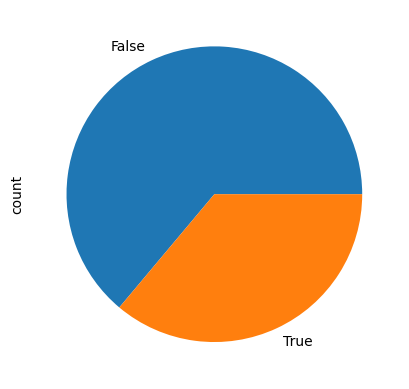

In [356]:
dataset['Outcome'].value_counts().plot.pie()

In [357]:
dataset.groupby('Gender', observed=True)['Outcome'].mean() # Se percentuale grande può causare leakage

Gender
Female    0.361486
Male      0.360777
Name: Outcome, dtype: float64

In [358]:
dataset.groupby('Gender', observed=True).size()

Gender
Female    386748
Male      393847
dtype: int64

In [359]:
dataset.describe()

,Age,BloodPressure
count,780595.000000,780595.000000
mean,57.148379,133.499806
std,15.778362,24.248001
min,20.000000,61.000000
25%,44.000000,114.000000
50%,57.000000,133.000000
75%,70.000000,153.000000
max,90.000000,199.000000


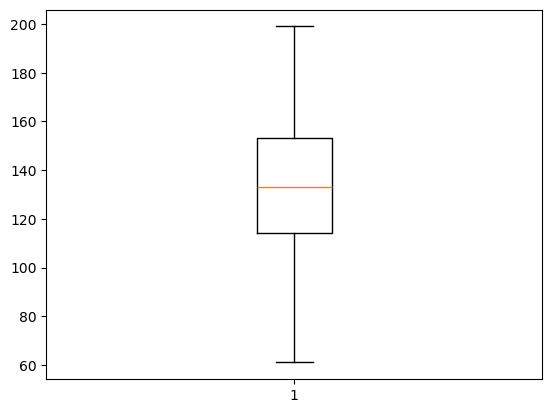

In [360]:
plt.boxplot(x="BloodPressure", data=dataset);  # NON ABBIAMO OUTLIERS

<Axes: ylabel='Smoker'>

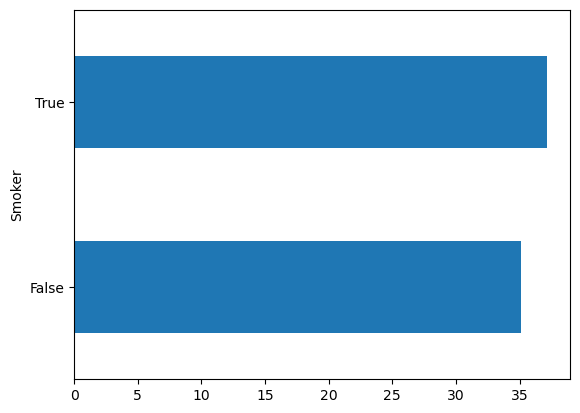

In [361]:
targetCorrelation(dataset, 'Smoker').plot.barh()

<Axes: ylabel='Cholesterol'>

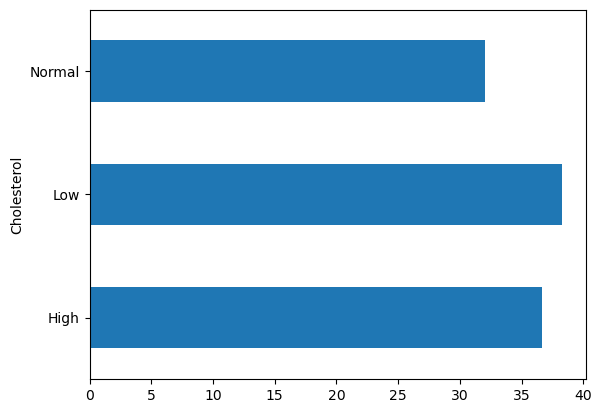

In [362]:
targetCorrelation(dataset, 'Cholesterol').plot.barh()

<Axes: ylabel='StressLevel'>

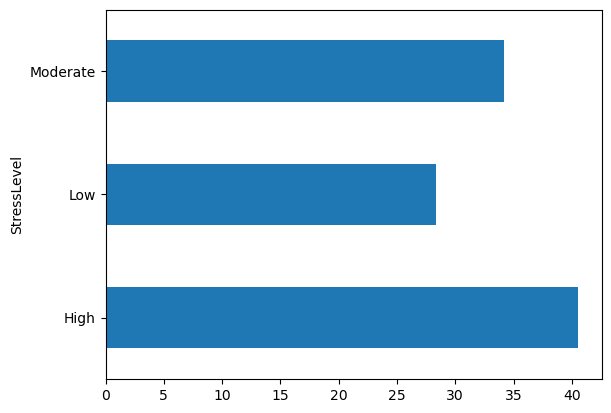

In [363]:
targetCorrelation(dataset, 'StressLevel').plot.barh()

<Axes: ylabel='StressLevel'>

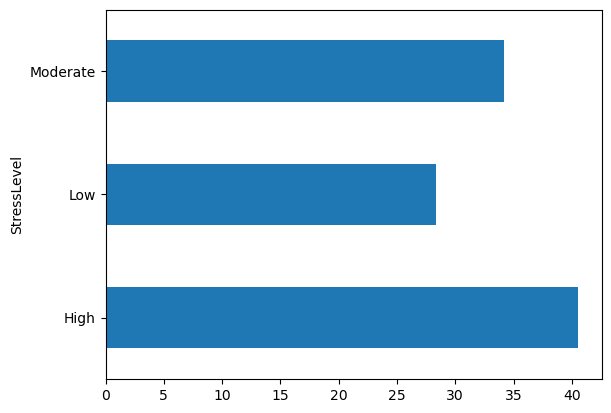

In [364]:
targetCorrelation(dataset, 'StressLevel').plot.barh()

<Axes: ylabel='Hypertension'>

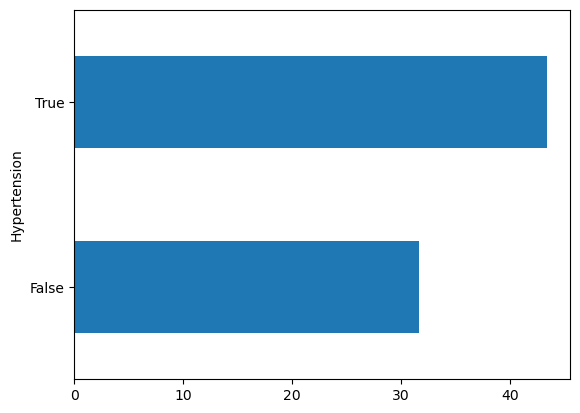

In [365]:
targetCorrelation(dataset, 'Hypertension').plot.barh()

<Axes: ylabel='PhysicalActivity'>

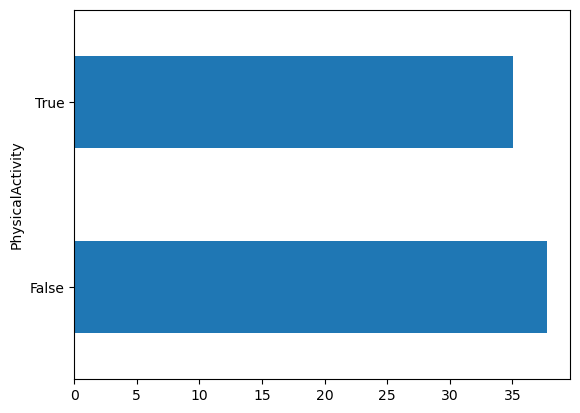

In [366]:
targetCorrelation(dataset, 'PhysicalActivity').plot.barh()

<Axes: ylabel='HealthyDiet'>

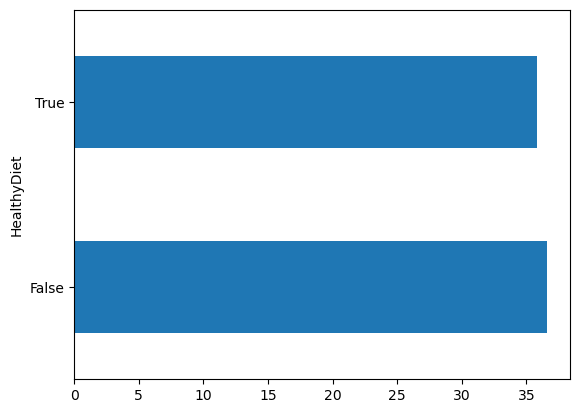

In [367]:
targetCorrelation(dataset, 'HealthyDiet').plot.barh()

<Axes: ylabel='IncomeLevel'>

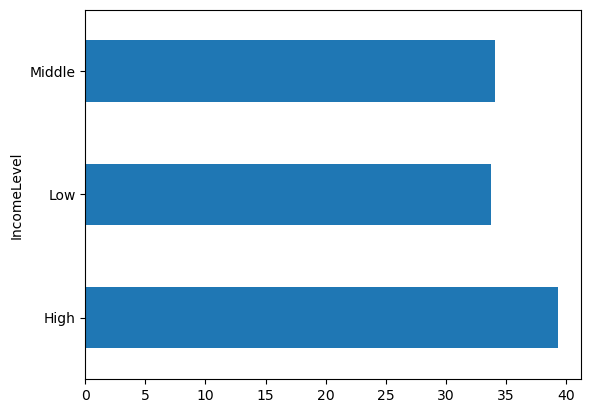

In [368]:
targetCorrelation(dataset, 'IncomeLevel').plot.barh()

<Axes: ylabel='FamilyHistory'>

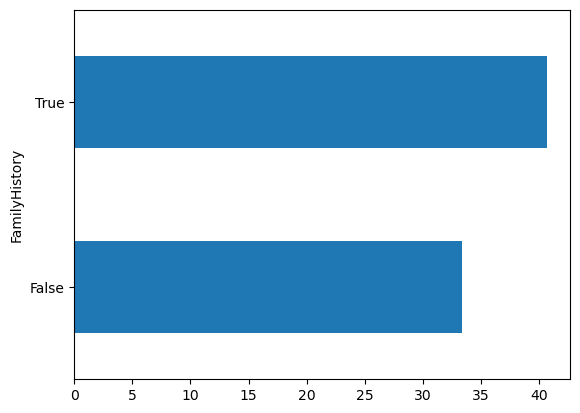

In [369]:
targetCorrelation(dataset, 'FamilyHistory').plot.barh()

<Axes: ylabel='PreviousHeartAttack'>

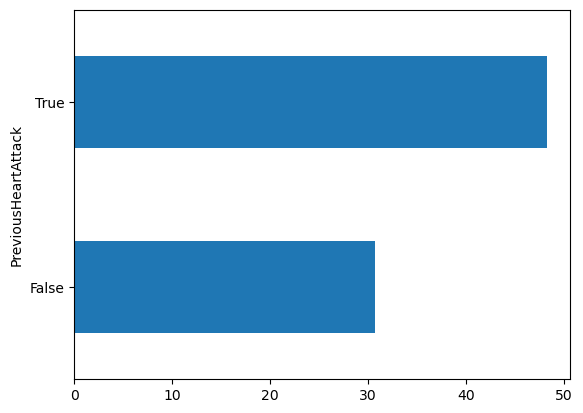

In [370]:
targetCorrelation(dataset, 'PreviousHeartAttack').plot.barh()

=== ELASTIC NET PATH ===



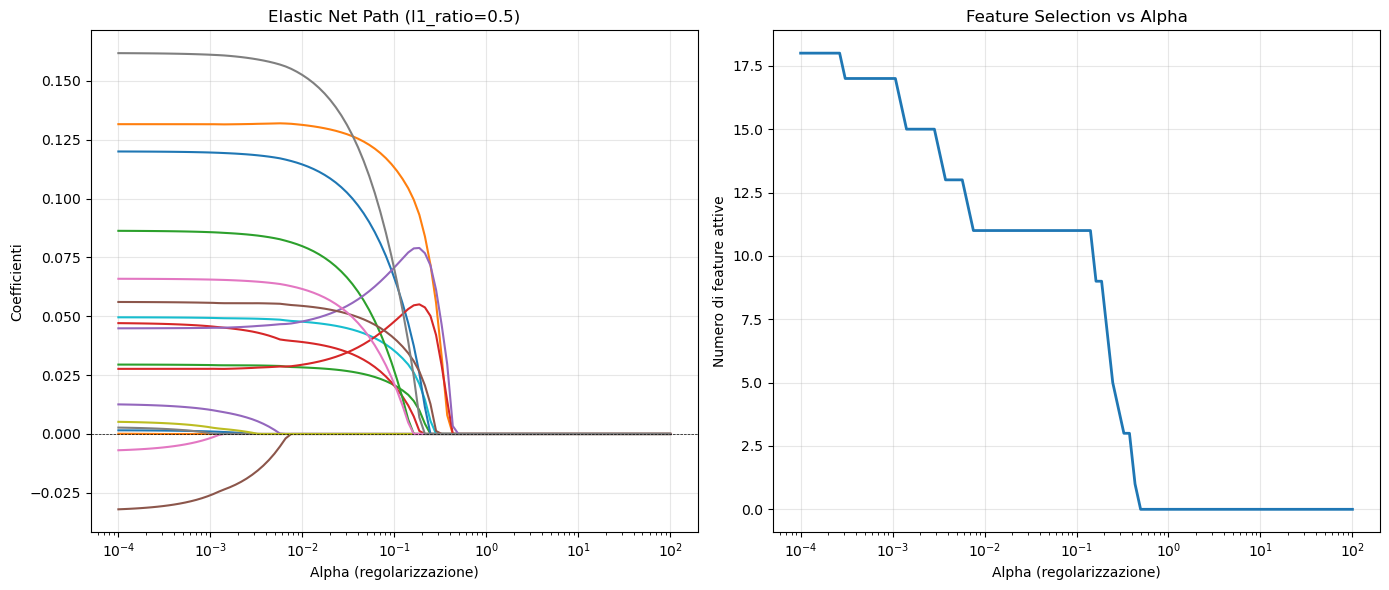

Alpha minimo testato: 0.000100
Alpha massimo testato: 100.000000
Numero massimo di feature attive: 18
Numero minimo di feature attive: 0



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, ElasticNetCV, enet_path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Features e target
# -------------------------------
X = dataset.drop('Outcome', axis=1)
y = dataset['Outcome'].astype(int)

# -------------------------------
# Definizione dei tipi di colonne
# -------------------------------
numeric_features = ['Age', 'BloodPressure']
binary_features = ['Smoker', 'Hypertension', 'Diabetes', 'Obesity',
                   'PhysicalActivity', 'HealthyDiet', 'AlcoholConsumption',
                   'FamilyHistory', 'PreviousHeartAttack']
categorical_features = ['Gender', 'Cholesterol', 'StressLevel', 'IncomeLevel']

# -------------------------------
# Preprocessing pipeline
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

# -------------------------------
# Split stratificato
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# ================================
# ELASTIC NET PATH
# ================================
print("=== ELASTIC NET PATH ===\n")

# Prepara i dati preprocessati
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Ottieni i nomi delle feature trasformate
feature_names = []
feature_names.extend(numeric_features)

# Feature categoriche dopo OneHotEncoding
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names.extend(cat_features)

feature_names.extend(binary_features)

# Converti in DataFrame
X_train_df = pd.DataFrame(X_train_prep, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_prep, columns=feature_names, index=X_test.index)

# Ricombina con il target
train_preprocessed = X_train_df.copy()
train_preprocessed['Outcome'] = y_train

test_preprocessed = X_test_df.copy()
test_preprocessed['Outcome'] = y_test

# Calcola il path
alphas = np.logspace(-4, 2, 100)
l1_ratio = 0.5

# enet_path restituisce (alphas, coefs, _)
alphas_path, coefs_path, _ = enet_path(
    X_train_prep, y_train,
    l1_ratio=l1_ratio,
    alphas=alphas,
    max_iter=10000
)

# Plot del path
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for i in range(coefs_path.shape[0]):
    plt.plot(alphas_path, coefs_path[i, :])
plt.xscale('log')
plt.xlabel('Alpha (regolarizzazione)')
plt.ylabel('Coefficienti')
plt.title(f'Elastic Net Path (l1_ratio={l1_ratio})')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.grid(True, alpha=0.3)

# Numero di feature non-zero per ogni alpha
plt.subplot(1, 2, 2)
n_nonzero = np.sum(np.abs(coefs_path) > 1e-5, axis=0)
plt.plot(alphas_path, n_nonzero, linewidth=2)
plt.xscale('log')
plt.xlabel('Alpha (regolarizzazione)')
plt.ylabel('Numero di feature attive')
plt.title('Feature Selection vs Alpha')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Alpha minimo testato: {alphas_path.min():.6f}")
print(f"Alpha massimo testato: {alphas_path.max():.6f}")
print(f"Numero massimo di feature attive: {n_nonzero.max()}")
print(f"Numero minimo di feature attive: {n_nonzero.min()}\n")

=== GRID SEARCH ===

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Migliori parametri: {'elastic_net__alpha': 0.0001, 'elastic_net__l1_ratio': 0.1}
Miglior MSE (CV): 0.2148

=== VALUTAZIONE MODELLO OTTIMIZZATO ===

=== TRAINING SET ===
MSE:  0.2148
RMSE: 0.2148
MAE:  0.4295
R²:   0.0692

=== TEST SET ===
MSE:  0.2148
RMSE: 0.2148
MAE:  0.4295
R²:   0.0691

=== COEFFICIENTI MODELLO OTTIMIZZATO ===

                 Feature  Coefficient  Abs_Coefficient
17   PreviousHeartAttack     0.137298         0.137298
11              Diabetes     0.111229         0.111229
10          Hypertension     0.093654         0.093654
5        StressLevel_Low    -0.071138         0.071138
12               Obesity     0.059454         0.059454
6   StressLevel_Moderate    -0.040169         0.040169
16         FamilyHistory     0.040083         0.040083
4     Cholesterol_Normal    -0.039403         0.039403
7        IncomeLevel_Low    -0.035015         0.035015
15    AlcoholConsumption     0.0

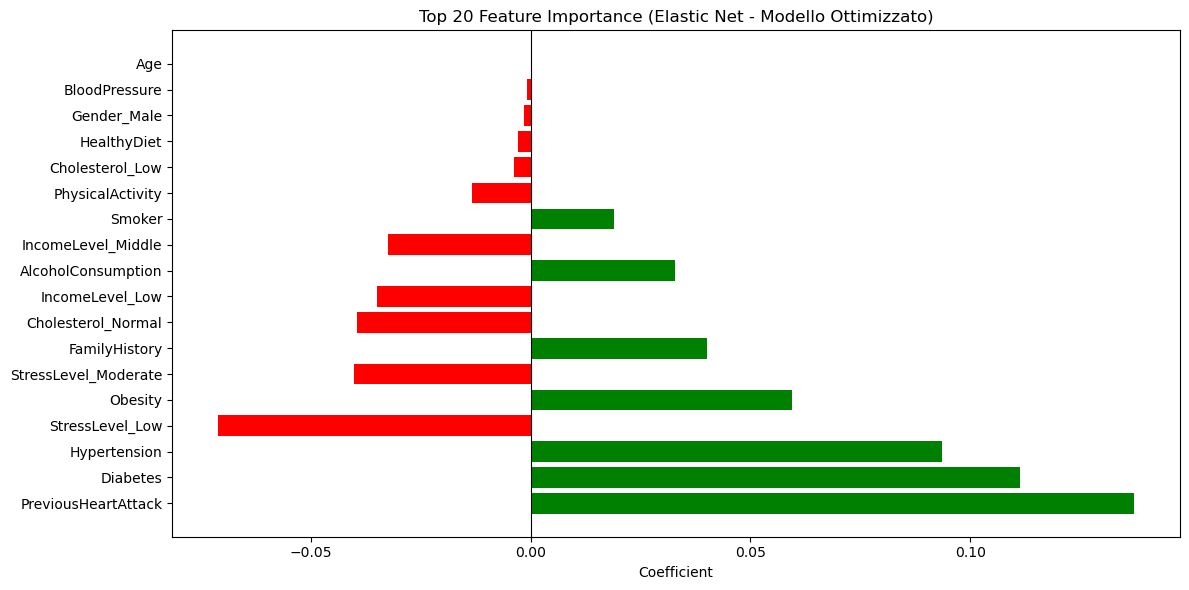

In [ ]:
# ================================
# GRID SEARCH
# ================================
print("=== GRID SEARCH ===\n")

# Pipeline completa
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('elastic_net', ElasticNet(random_state=42, max_iter=10000))
])

# Parametri da testare
param_grid = {
    'elastic_net__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
    'elastic_net__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

# Grid search con cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print(f"\nMigliori parametri: {grid_search.best_params_}")
print(f"Miglior MSE (CV): {-grid_search.best_score_:.4f}")

# ================================
# VALUTAZIONE MODELLO OTTIMIZZATO
# ================================
print("\n=== VALUTAZIONE MODELLO OTTIMIZZATO ===\n")

best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print("=== TRAINING SET ===")
print(f"MSE:  {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"RMSE: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"MAE:  {mean_absolute_error(y_train, y_pred_train):.4f}")
print(f"R²:   {r2_score(y_train, y_pred_train):.4f}")

print("\n=== TEST SET ===")
print(f"MSE:  {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"R²:   {r2_score(y_test, y_pred_test):.4f}")

# ================================
# ANALISI COEFFICIENTI
# ================================
print("\n=== COEFFICIENTI MODELLO OTTIMIZZATO ===\n")

coefficients = best_model.named_steps['elastic_net'].coef_

# Ottieni i nomi delle feature
feature_names = []
feature_names.extend(numeric_features)

cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names.extend(cat_features)

feature_names.extend(binary_features)

# DataFrame con coefficienti
import pandas as pd
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print(coef_df.head(15))

# Feature inutili (coeff ≈ 0)
threshold = 1e-5
useless_features = coef_df[coef_df['Abs_Coefficient'] < threshold]
print(f"\n=== FEATURE INUTILI (coeff ≈ 0) ===")
print(f"Numero: {len(useless_features)}")
print(useless_features)

# Plot top feature
plt.figure(figsize=(12, 6))
top_features = coef_df.head(20)
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(top_features['Feature'], top_features['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.title('Top 20 Feature Importance (Elastic Net - Modello Ottimizzato)')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

In [374]:
# ================================
# CONFRONTO RISULTATI CV
# ================================
print("\n=== CONFRONTO TOP 5 CONFIGURAZIONI ===\n")

results_df = pd.DataFrame(grid_search.cv_results_)
results_df['mean_mse'] = -results_df['mean_test_score']
results_df = results_df.sort_values('mean_mse')

top_5 = results_df[['param_elastic_net__alpha', 'param_elastic_net__l1_ratio', 'mean_mse']].head(5)
print(top_5.to_string(index=False))


=== CONFRONTO TOP 5 CONFIGURAZIONI ===

 param_elastic_net__alpha  param_elastic_net__l1_ratio  mean_mse
                   0.0001                          0.1  0.214764
                   0.0001                          0.3  0.214764
                   0.0001                          0.5  0.214765
                   0.0001                          0.7  0.214765
                   0.0001                          0.9  0.214765


In [375]:
X_train_df

Age  BloodPressure  Gender_Male  \
State         PatientID                                         
Indonesia     27502      0.940446      -0.884956          0.0   
China         221521    -1.214470      -1.256041          1.0   
              225614    -0.707431      -1.709589          0.0   
Indonesia     101934    -0.073632       0.104603          1.0   
China         69362     -0.644051      -0.472640          0.0   
...                           ...            ...          ...   
Indonesia     87839      0.877066      -0.348945          1.0   
China         107458     1.003826       0.145835          0.0   
United States 347237     0.813686      -0.761261          1.0   
              253921    -0.200392       0.351993          0.0   
Indonesia     11355      0.370027       0.145835          0.0   

                         Cholesterol_Low  Cholesterol_Normal  StressLevel_Low  \
State         PatientID                                                         
Indonesia     27502                  0.0                 1.0              0.0   
China         221521                 0.0                 1.0              1.0   
              225614                 0.0                 1.0              1.0   
Indonesia     101934                 1.0                 0.0              0.0   
China         69362                  0.0                 0.0              0.0   
...                                  ...                 ...              ...   
Indonesia     87839                  1.0                 0.0              0.0   
China         107458                 1.0                 0.0              1.0   
United States 347237                 1.0                 0.0              0.0   
              253921                 0.0                 0.0              0.0   
Indonesia     11355                  0.0                 0.0              0.0   

                         StressLevel_Moderate  IncomeLevel_Low  \
State         PatientID                                          
Indonesia     27502                       1.0              0.0   
China         221521                      0.0              1.0   
              225614                      0.0              1.0   
Indonesia     101934                      0.0              1.0   
China         69362                       1.0              1.0   
...                                       ...              ...   
Indonesia     87839                       0.0              1.0   
China         107458                      0.0              1.0   
United States 347237                      0.0              0.0   
              253921                      1.0              1.0   
Indonesia     11355                       1.0              1.0   

                         IncomeLevel_Middle  Smoker  Hypertension  Diabetes  \
State         PatientID                                                       
Indonesia     27502                     1.0     1.0           0.0       1.0   
China         221521                    0.0     0.0           1.0       0.0   
              225614                    0.0     0.0           0.0       0.0   
Indonesia     101934                    0.0     1.0           1.0       1.0   
China         69362                     0.0     1.0           1.0       1.0   
...                                     ...     ...           ...       ...   
Indonesia     87839                     0.0     0.0           0.0       1.0   
China         107458                    0.0     0.0           0.0       0.0   
United States 347237                    1.0     0.0           0.0       1.0   
              253921                    0.0     0.0           0.0       0.0   
Indonesia     11355                     0.0     0.0           0.0       1.0   

                         Obesity  PhysicalActivity  HealthyDiet  \
State         PatientID                                           
Indonesia     27502          0.0               0.0          0.0   
China         221521         0.0          

In [ ]:
# STRESS LEVEL LOW E MODERATE
# CHOLESTEROL NORMAL
# INCOME LEVEL LOW E MIDDLE
# PHYSICAL ACTIVITY